In [1]:
import pandas as pd
import numpy as np
import numpy as np
import statsmodels.api as sm 
from statsmodels.tsa.vector_ar.var_model import VAR
tsa = sm.tsa

%matplotlib inline

#### Suppose we want to model a simple linear model that links the stock of money in the economy to real GDP and consumer price index CPI, we could just transform the data and fit the model with OLS:

In [2]:
tsa = sm.tsa # as shorthand
mdata = sm.datasets.macrodata.load().data
endog = np.log(mdata['m1'])
exog = np.column_stack([np.log(mdata['realgdp']),
                        np.log(mdata['cpi'])])
exog = sm.add_constant(exog, prepend=True)
res1 = sm.OLS(endog, exog).fit()

In [7]:
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9871.
Date:                Tue, 31 May 2016   Prob (F-statistic):          1.34e-200
Time:                        19:23:16   Log-Likelihood:                 221.75
No. Observations:                 203   AIC:                            -437.5
Df Residuals:                     200   BIC:                            -427.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.5016      0.353     -4.256      0.0

#### The Durbin-Watson statistic that is included in the summary is very low indicating that there is a strong autocorrelation in the residuals. As a more formal test we can calculate the autocorrelation, the Ljung-Box Q-statistic for the test of zero autocorrelation and the associated p-values:

In [14]:
acf, Q, pvalue = tsa.acf(res1.resid, nlags=4, qstat=True,unbiased=True) 

acf


array([ 1.        ,  0.98234045,  0.94759323,  0.90362911,  0.84956461])

In [12]:
pvalue

array([  3.81138443e-045,   2.89157008e-084,   6.94932940e-120,
         2.19208642e-151,   2.70075899e-179,   1.10852554e-203,
         1.79967250e-224,   6.82004422e-242,   3.27549755e-256,
         8.11698226e-268,   4.31842891e-277,   2.31078978e-284,
         4.99399528e-290,   1.89576730e-294,   8.36898005e-298,
         2.64483541e-300,   4.05013285e-302,   2.47491143e-303,
         4.33141841e-304,   1.78073588e-304])

In [15]:
tsa.pacf(res1.resid, nlags=4)

array([ 1.        ,  0.98234045, -0.49702659, -0.06231143, -0.22697109])

### Testing stationarity

#### Testing the log of the stock of money with a null hypothesis of unit roots against an alternative of stationarity around a linear trend, shows an adf-statistic of -1.5 and a p-value of 0.8, so we are far away from rejecting the unit root hypothesis:

In [6]:
tsa.adfuller(endog, regression="ct")

(-1.7691857007088059,
 0.71942351233729673,
 5,
 197,
 {'1%': -4.0054748800496718,
  '10%': -3.1402789366915127,
  '5%': -3.4330150618380553},
 -1158.4730213033745)

#### If we test the differenced series, that is the growth rate of moneystock, with a Null hypothesis of Random Walk with drift, then we can strongly reject the hypothesis that the growth rate has a unit root (p-value 0.0002) and is stationary.

In [17]:
tsa.adfuller(np.diff(endog), regression="c")[:2]

(-3.8664128034356215, 0.0022964162084422881)

### VECTOR AUTOREGRESSION

#### In this example we wish to understand the impact of monetary policy on inflation and unemployment. A widely used tool for analyzing multiple time series is the vector autoregressive (VAR) model not just monetary policy on itself.

In [10]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)


In [11]:
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

In [12]:
model = VAR(data)
results=model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 31, May, 2016
Time:                     19:31:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.174
L1.realgdp         -0.279435         0.169663           -1.647           0.101
L1.realcons         0.675016         0.131285            5.142    

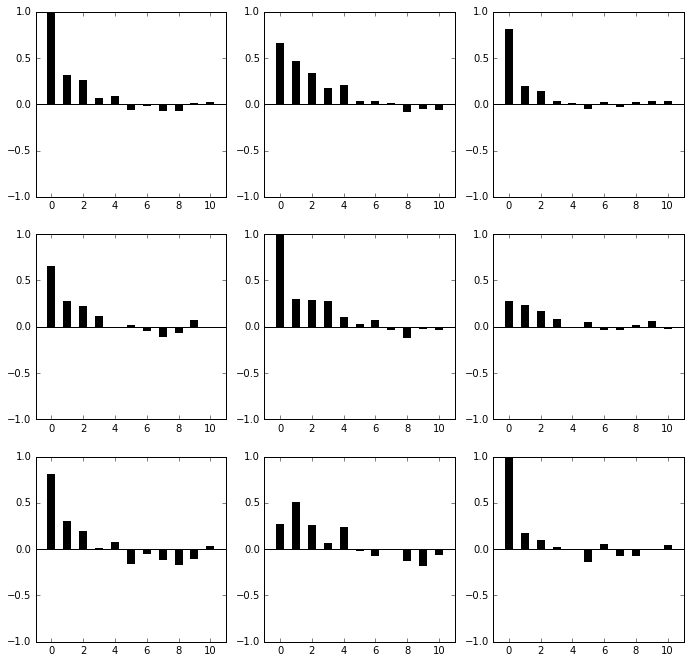

In [13]:
results.plot_sample_acorr()

### Choosing the correct number of lags 

#### Stats model has a couple of built in ways to for choosing the number of lags automatically based on specified criterea 

In [14]:
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -27.70       -27.65    9.358e-13       -27.68
1        -28.02      -27.82*    6.745e-13      -27.94*
2        -28.03       -27.66    6.732e-13       -27.88
3       -28.04*       -27.52   6.651e-13*       -27.83
4        -28.03       -27.36    6.681e-13       -27.76
5        -28.02       -27.19    6.773e-13       -27.69
6        -27.97       -26.98    7.147e-13       -27.57
7        -27.93       -26.79    7.446e-13       -27.47
8        -27.94       -26.64    7.407e-13       -27.41
9        -27.96       -26.50    7.280e-13       -27.37
10       -27.91       -26.30    7.629e-13       -27.26
11       -27.86       -26.09    8.076e-13       -27.14
12       -27.83       -25.91    8.316e-13       -27.05
13       -27.80       -25.73    8.594e-13       -26.96
14       -27.80       -25.57    8.627e-13       -26.90
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

#### And

In [15]:
results = model.fit(maxlags=15, ic='bic')

In [16]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 31, May, 2016
Time:                     19:32:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7388
Nobs:                     201.000    HQIC:                  -27.8562
Log likelihood:           1963.94    FPE:                7.37174e-13
AIC:                     -27.9360    Det(Omega_mle):     6.94859e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003580         0.000911            3.928           0.000
L1.realgdp         -0.338056         0.172084           -1.964           0.051
L1.realcons         0.746283         0.130411            5.723    

### Impulse Response Analysis (IRF)

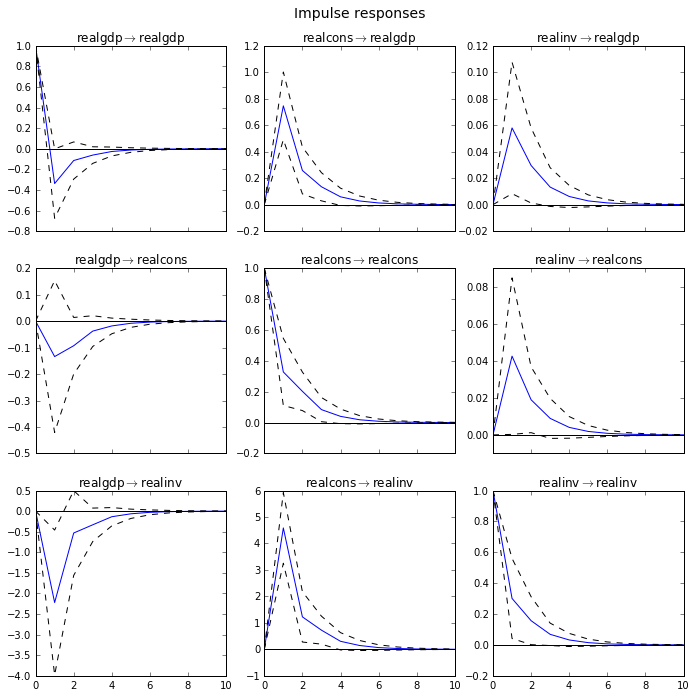

In [17]:
##Impulse responses can be generated and plotted thusly:
irf = results.irf(10) # 10 periods
irf.plot()

### GRANGER CAUSALITY

#### Testing Granger causality can be carried out using the results object:

In [35]:
##testing Granger causality can be carried out using the results object:
results.test_causality('realgdp',['realcons', 'realinv'])

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         6.999888         2.114554            0.000  (6, 567)
H_0: ['realcons', 'realinv'] do not Granger-cause realgdp
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.1145543864563141,
 'df': (6, 567),
 'pvalue': 3.3805963773887378e-07,
 'signif': 0.05,
 'statistic': 6.9998875522543536}

#### In this case we are testing whether realcons and realinv Granger-cause realgdp with our null hypothesis being that they don't.  As you can see, we reject reject the null hypothesis and conclude that realcons and realinv do Granger-cause realgdp. 

### FORECAST ERROR VARIANCE DECOMPOSITION

#### The forecast error variance decomposition can also be computed and plotted like so

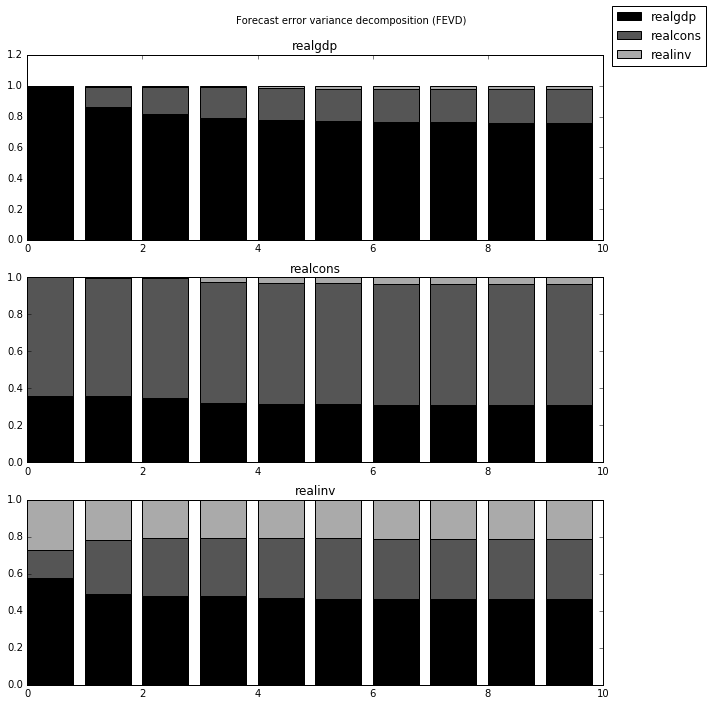

In [36]:
##n-step ahead forecasts can similarly be generated and plotted: 
#results.plot_forecast(10)
##The forecast error variance decomposition can also be computed and plotted like so
results.fevd().plot()

### FORECASTING

### n-step ahead forecasts can similarly be generated and plotted: 

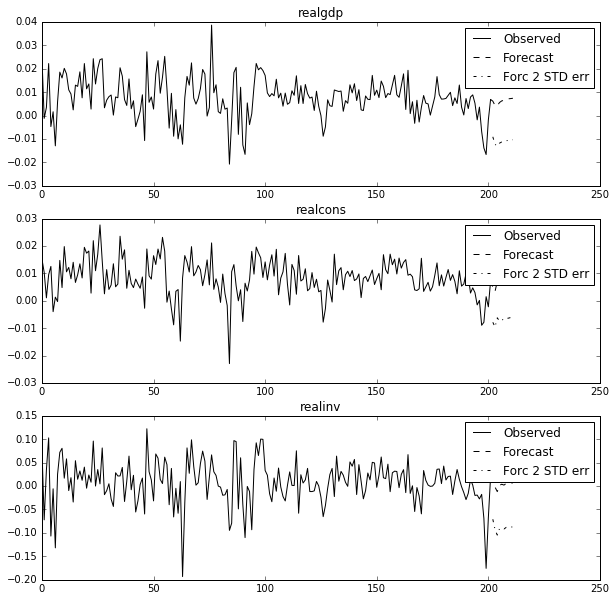

In [39]:
results.plot_forecast(10)

In [50]:
results.forecast(np.array(data[-50:], np.int32),10)
##pd.DataFrame(results.forecast(np.array(data[-10:], np.int32),10),columns=list(data.columns))

array([[ 0.00128149,  0.00483719, -0.02059736],
       [ 0.00354461,  0.00541925, -0.00629219],
       [ 0.00548619,  0.00642947,  0.00191751],
       [ 0.0062836 ,  0.00731851,  0.00255266],
       [ 0.00678391,  0.00756193,  0.00516369],
       [ 0.00709833,  0.00780934,  0.00607303],
       [ 0.00727774,  0.00798375,  0.00642959],
       [ 0.0074105 ,  0.008073  ,  0.00698977],
       [ 0.0075011 ,  0.00814292,  0.0072853 ],
       [ 0.00755726,  0.00818895,  0.00746156]])

In [51]:
pd.DataFrame(results.forecast(np.array(data[-10:], np.int32),10),columns=list(data.columns))

,realgdp,realcons,realinv
0,0.001281,0.004837,-0.020597
1,0.003545,0.005419,-0.006292
2,0.005486,0.006429,0.001918
3,0.006284,0.007319,0.002553
4,0.006784,0.007562,0.005164
5,0.007098,0.007809,0.006073
6,0.007278,0.007984,0.006430
7,0.007410,0.008073,0.006990
8,0.007501,0.008143,0.007285
9,0.007557,0.008189,0.007462
